In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from pathlib import Path
import geopandas as gpd
from datetime import datetime

import pytorch_lightning as pl
from torchgeo.datasets import BoundingBox
from rts_utils import get_time_bounds
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import RichProgressBar
from torchgeo.models import ResNet50_Weights

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from rts_datamodule_retreat import LandsatPairInferenceDataModule
from rts_model_retreat import SiameseRTS
from rts_inference_retreat import predict_and_export

In [4]:
from rts_path import img_dir, dem_dir

Running on cryo-A100


In [5]:
UTM_CRS = "EPSG:32646"

polygon_dir = Path('/DATA/DATA1/joey/rts_polygons/')
rts_extent_gdf_path = polygon_dir / 'beiluhe_hoh_xil_mountain_extent_utm.gpkg'
rts_extent_gdf = gpd.read_file(rts_extent_gdf_path)
mint = datetime.strptime('19860101', "%Y%m%d").timestamp() # parse time_str then convert to POSIX timestamp
maxt = datetime.strptime('20231231', "%Y%m%d").timestamp()
minx, miny, maxx, maxy = rts_extent_gdf.total_bounds
test_roi = BoundingBox(minx, maxx, miny, maxy, mint, maxt)
test_roi

BoundingBox(minx=np.float64(437815.9904658653), maxx=np.float64(515098.9866292246), miny=np.float64(3837062.6820999067), maxy=np.float64(3929936.5625385013), mint=504892800.0, maxt=1703952000.0)

In [6]:
BAND_NUM = 4
USE_DEM = True

if BAND_NUM == 3:
    landsat_bands = ['SR_B4', 'SR_B3', 'SR_B2']  # in R G B order
elif BAND_NUM == 4:
    landsat_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']
elif BAND_NUM == 6:
    landsat_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

In [7]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(
    project="rts_retreat_project",
    name="unetpp_rgb_nir_dem_vinfer",
    save_dir="wandb_logs"
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    max_epochs=30,
    log_every_n_steps=35,
    logger=wandb_logger,
    enable_progress_bar=True,
    callbacks=[RichProgressBar(leave=False)]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
# ckpt_dir = Path(logger.save_dir) / logger.name / f'version_{logger.version-2}' / 'checkpoints'
# ckpt_path_best = list(ckpt_dir.glob('epoch*.ckpt'))[0]
# ckpt_path_best = Path(logger.save_dir) / logger.name / "best_model.ckpt"
# print(ckpt_path_best)

# ckpt_path_best = Path("lightning_logs") / logger_name / "version_52" / "checkpoints" / "epoch=45-step=4600.ckpt"
# logger_name = "rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test"

# ckpt_path_best = Path("lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_58/checkpoints/epoch=54-step=5500.ckpt")
ckpt_path_best = Path("wandb_logs/rts_retreat_project/afums907/checkpoints/epoch=65-step=6600.ckpt")
print("Best ckpt:", ckpt_path_best)

rts_model = SiameseRTS.load_from_checkpoint(checkpoint_path=ckpt_path_best,
                                          encoder_name="resnet50",
                                          encoder_weights=ResNet50_Weights.SENTINEL2_ALL_MOCO,
                                          in_bands=landsat_bands,
                                          use_dem=USE_DEM,
                                          out_classes=2
                                          )


Best ckpt: wandb_logs/rts_retreat_project/afums907/checkpoints/epoch=65-step=6600.ckpt
ResNet50_Weights.SENTINEL2_ALL_MOCO  loaded
input shape of target weight torch.Size([64, 5, 7, 7])
input shape of loaded weight torch.Size([64, 13, 7, 7])


In [9]:
from pathlib import Path

BAND_NUM = 4
USE_DEM = True

test_year_t = 2017
test_year_tm1 = 2016

if test_year_t > 2012:
    dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LC08_MIX/')
else:
    dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LT05_MIX/')

year_dir = dataset_dir / f"{test_year_t}"
test_img_dir = year_dir / "test"   # 只用于检查是否有文件
print("推理影像目录:", test_img_dir)

landsat_dm_inf = LandsatPairInferenceDataModule(
    img_dir=str(test_img_dir),          # 注意：传 year 调用 TestLandsat*，不是 year/test
    year_t=test_year_t,
    year_tm1=test_year_tm1,
    roi=test_roi,                  # 你的目标 ROI (BoundingBox)
    dem_dir=str(dem_dir),
    band_num=BAND_NUM,             # 例如 4
    use_dem=USE_DEM,               # True
    batch_size=1,
    crs=UTM_CRS,
    res=30,
    use_l7=False, # for DEBUG
    num_workers=0,
)

推理影像目录: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2017/test
🔧 创建多年份数据集，年份: [2017, 2016]
检测到年份目录结构，基础目录: /DATA/DATA1/joey/LANDSAT_LC08_MIX
  添加年份 2017: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2017/test
[TestLandsat8SR] Reindexed 5 files by directory year
    L8/9 数据集创建成功，边界: BoundingBox(minx=437155.9904658653, maxx=515115.0, miny=3836006.562538497, maxy=3930075.0, mint=1483200000.0, maxt=1514735999.0)
  添加年份 2016: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2016/test
[TestLandsat8SR] Reindexed 3 files by directory year
    L8/9 数据集创建成功，边界: BoundingBox(minx=437815.9904658653, maxx=515115.0, miny=3836925.0, maxy=3930075.0, mint=1451577600.0, maxt=1483199999.0)
最终数据集 (仅L8/9)，边界: BoundingBox(minx=437155.9904658653, maxx=515115.0, miny=3836006.562538497, maxy=3930075.0, mint=1451577600.0, maxt=1514735999.0)
[TestLandsat8SR] Reindexed 5 files by directory year


In [10]:
# 让 datamodule 构建内部 dataset/sampler
landsat_dm_inf.prepare_data()
landsat_dm_inf.setup("predict")

In [11]:
rts_model.eval()
predictions = trainer.predict(
    model=rts_model,
    dataloaders=landsat_dm_inf.predict_dataloader()
)

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.

wandb: Currently logged in as: wei-wu24 (wei-wu24-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


In [13]:
print("num batches:", len(predictions))

num batches: 8


In [14]:
batch_pred = predictions[0]  # 第一个 batch 的预测结果

image_t = batch_pred["image_t"]      # [B,C,H,W]
image_tm1 = batch_pred["image_tm1"]    # [B,C,H,W]
pred_heat = batch_pred["heatmap"]    # [B,1,H,W]
pred_ret = batch_pred["retreat"] # [B,1,H,W]，已乘 retreat_scale
prob_mask = batch_pred["prob_mask"]    # [B,1,H,W]

In [15]:
import rasterio
import numpy as np
from rasterio.transform import from_bounds

# 重新生成 dataloader 的迭代器
predict_loader = landsat_dm_inf.predict_dataloader()
batch_iter = iter(predict_loader)

for i, batch_pred in enumerate(predictions):
    # 取对应的 batch（和 predictions 顺序一致）
    batch = next(batch_iter)
    heat = batch_pred["heatmap"][0, 0].cpu().numpy().astype(np.float32)
    mask = batch_pred["prob_mask"][0, 0].cpu().numpy().astype(np.float32)
    h, w = heat.shape

    bbox = batch["bbox"]
    transform = from_bounds(bbox.minx, bbox.miny, bbox.maxx, bbox.maxy, w, h)
    crs = batch["crs"]

    save_path = f"single_patch_pred_{i:03d}.tif"
    with rasterio.open(
        save_path,
        "w",
        driver="GTiff",
        height=h,
        width=w,
        count=2,
        dtype="float32",
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(heat, 1)
        dst.set_band_description(1, "heatmap")
        dst.write(mask, 2)
        dst.set_band_description(2, "prob_mask")

    print(f"已保存单patch推理结果: {save_path}")

已保存单patch推理结果: single_patch_pred_000.tif
已保存单patch推理结果: single_patch_pred_001.tif
已保存单patch推理结果: single_patch_pred_002.tif
已保存单patch推理结果: single_patch_pred_003.tif
已保存单patch推理结果: single_patch_pred_004.tif
已保存单patch推理结果: single_patch_pred_005.tif
已保存单patch推理结果: single_patch_pred_006.tif
已保存单patch推理结果: single_patch_pred_007.tif


Sample 0:
Heat range: -0.03350908309221268 0.739830493927002
Retreat range: -0.9845789074897766 1.0376838445663452
Prob range: 2.0159032003541353e-33 1.0


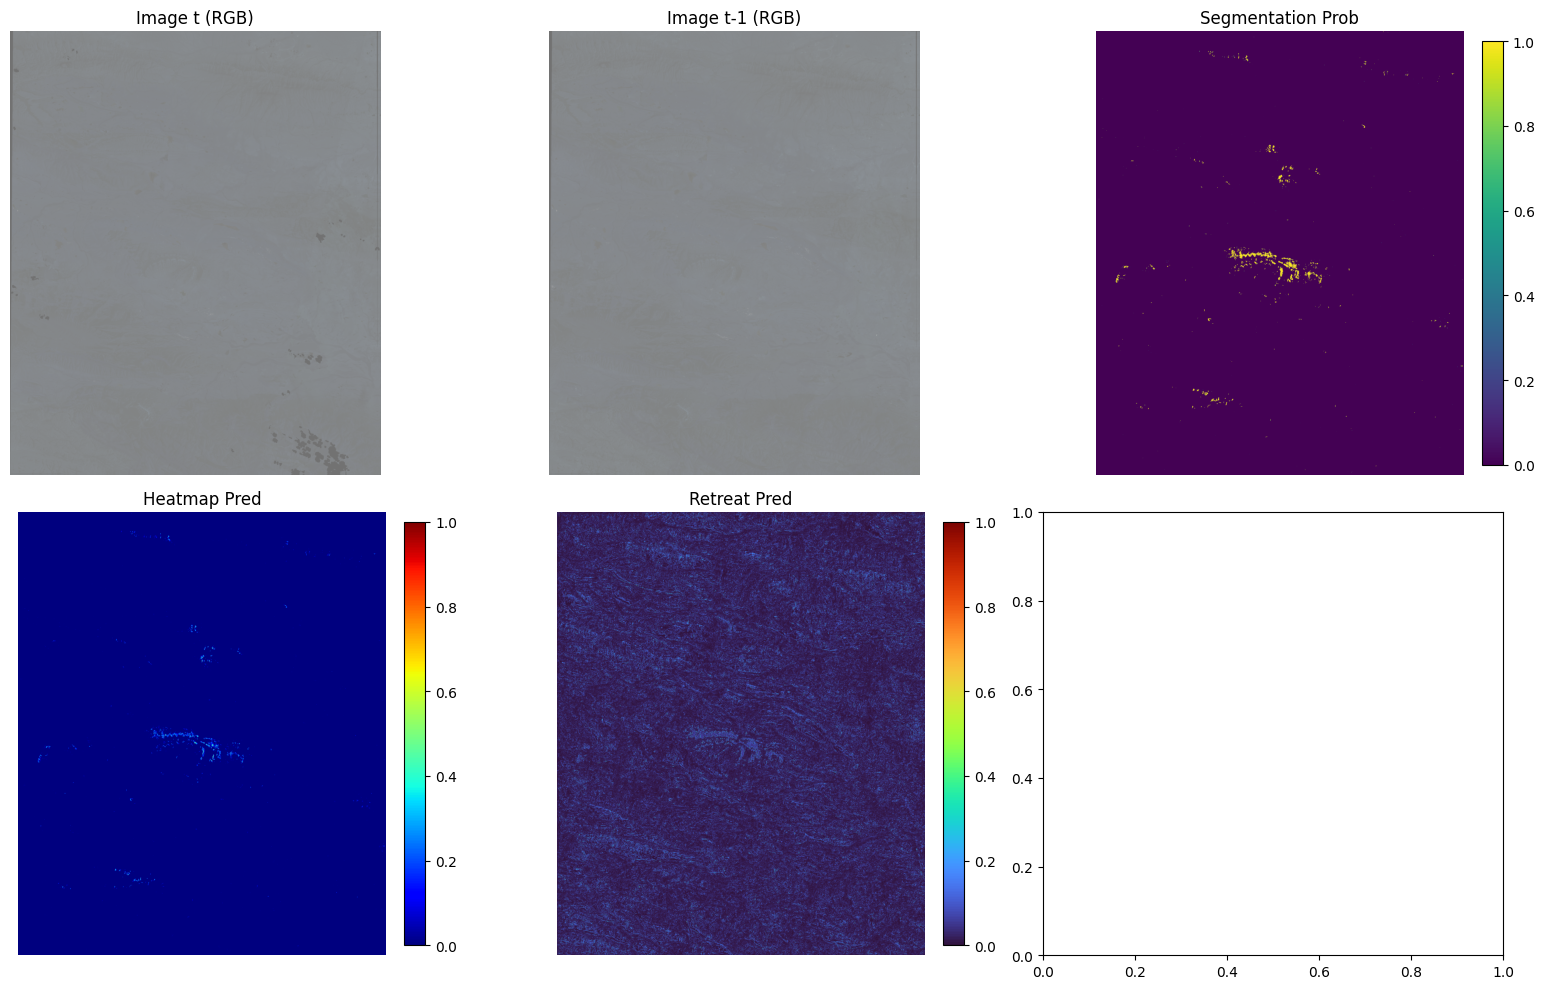

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def percentile_stretch(img, low=2, high=98):
    if img.ndim == 3:
        result = np.zeros_like(img, dtype=np.float32)
        for c in range(img.shape[2]):
            channel = img[:, :, c]
            p_low = np.percentile(channel, low)
            p_high = np.percentile(channel, high)
            if p_high - p_low > 1e-6:
                result[:, :, c] = np.clip((channel - p_low) / (p_high - p_low), 0, 1)
            else:
                result[:, :, c] = 0.5
        return result
    else:
        p_low = np.percentile(img, low)
        p_high = np.percentile(img, high)
        if p_high - p_low > 1e-6:
            return np.clip((img - p_low) / (p_high - p_low), 0, 1)
        else:
            return np.full_like(img, 0.5, dtype=np.float32)

def vis_batch(image_t, image_tm1, prob_mask, pred_heat, pred_ret, max_samples=4):
    B = image_t.shape[0]
    N = min(B, max_samples)

    for i in range(N):
        img_t = image_t[i]      # [C,H,W]
        img_tm1 = image_tm1[i]
        pm = prob_mask[i, 0].numpy()      # [H,W]
        h_pr = pred_heat[i, 0].numpy()      # [H,W]
        r_pr = pred_ret[i, 0].numpy()       # [H,W]

        # RGB_t
        if img_t.shape[0] >= 3:
            rgb_t = img_t[:3].numpy().transpose(1, 2, 0)  # [H,W,3]
            # 如果训练时做了标准化，可以简单做一个反向/clip，这里只作裁剪方便看
            rgb_t = np.clip((rgb_t + 2) / 4, 0, 1)
            # rgb_t = percentile_stretch(rgb_t)
        else:
            rgb_t = img_t[0].numpy()

        # RGB_tm1
        if img_tm1.shape[0] >= 3:
            rgb_tm1 = img_tm1[:3].numpy().transpose(1, 2, 0)
            rgb_tm1 = np.clip((rgb_tm1 + 2) / 4, 0, 1)
            # rgb_tm1 = percentile_stretch(rgb_tm1)
        else:
            rgb_tm1 = img_tm1[0].numpy()

        print(f"Sample {i}:")
        print("Heat range:", float(h_pr.min()), float(h_pr.max()))
        print("Retreat range:", float(r_pr.min()), float(r_pr.max()))
        print("Prob range:", float(pm.min()), float(pm.max()))

        fig, axes = plt.subplots(2, 3, figsize=(16, 10))

        axes[0, 0].imshow(rgb_t)
        axes[0, 0].set_title("Image t (RGB)")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(rgb_tm1)
        axes[0, 1].set_title("Image t-1 (RGB)")
        axes[0, 1].axis("off")

        im = axes[0, 2].imshow(pm, vmin=0, vmax=1, cmap="viridis")
        axes[0, 2].set_title("Segmentation Prob")
        axes[0, 2].axis("off")
        fig.colorbar(im, ax=axes[0, 2], fraction=0.046, pad=0.04)

        im = axes[1, 0].imshow(h_pr, vmin=0, vmax=1, cmap="jet")
        axes[1, 0].set_title("Heatmap Pred")
        axes[1, 0].axis("off")
        fig.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)

        im = axes[1, 1].imshow(r_pr, vmin=0, vmax=1, cmap="turbo")
        axes[1, 1].set_title("Retreat Pred")
        axes[1, 1].axis("off")
        fig.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

        # Overlay: 在 t 年 RGB 上叠加 heat 高值和 retreat 高值轮廓
        # axes[1, 2].imshow(rgb_t)
        # try:
        #     heat_thr = h_pr.min() + 0.7 * (h_pr.max() - h_pr.min())
        #     ret_thr = r_pr.min() + 0.7 * (r_pr.max() - r_pr.min())
        #     axes[1, 2].contour(h_pr >= heat_thr, colors="yellow", linewidths=1)
        #     axes[1, 2].contour(r_pr >= ret_thr, colors="red", linewidths=1)
        #     axes[1, 2].set_title("RGB + Heat(y) + Retreat(r)")
        # except Exception:
        #     axes[1, 2].set_title("RGB overlay")
        # axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

# 调用
vis_batch(image_t, image_tm1, prob_mask, pred_heat, pred_ret, max_samples=4)

In [18]:
suffix = "dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s"
export_dir = Path(f"/DATA/DATA1/ww/pr_mask_rts_aea_{suffix}")

predict_and_export(
    rts_model,
    trainer,
    landsat_dm_inf,
    model_name="unetpp_rgb_nir_dem_moco_blh_hxm",
    date_str=f"{test_year_t}0731",
    export_dir=export_dir,
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


KeyError: 'transform'

In [17]:
from pathlib import Path
import rasterio
import numpy as np

predict_path = Path(export_dir) / f"pr_mask_{test_year_t}0731_median_unetpp_rgb_nir_dem_moco_blh_hxm.tif"

with rasterio.open(predict_path) as src:
    pr_heatmap_median = src.read(1)

print("pr_heatmap_median stats:",
      "min", float(pr_heatmap_median.min()),
      "max", float(pr_heatmap_median.max()),
      "mean", float(pr_heatmap_median.mean()),
      "nonzero", int((pr_heatmap_median > 0).sum()))

pr_heatmap_median stats: min -0.01011544931679964 max 0.5224249362945557 mean 0.00034726125886663795 nonzero 4000736


掩膜阈值: segment > 0.5
掩膜内像素数: 16076
原始 heatmap 非零像素: 4017285
掩膜后 heatmap 非零像素: 16076
掩膜后 heatmap 范围: [0.0000, 0.5041]


/tmp/ipykernel_2139073/3939221879.py:54: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2139073/3939221879.py:54: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2139073/3939221879.py:54: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2139073/3939221879.py:54: UserWarning: Glyph 38646 (\N{CJK UNIFIED IDEOGRAPH-96F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) mi

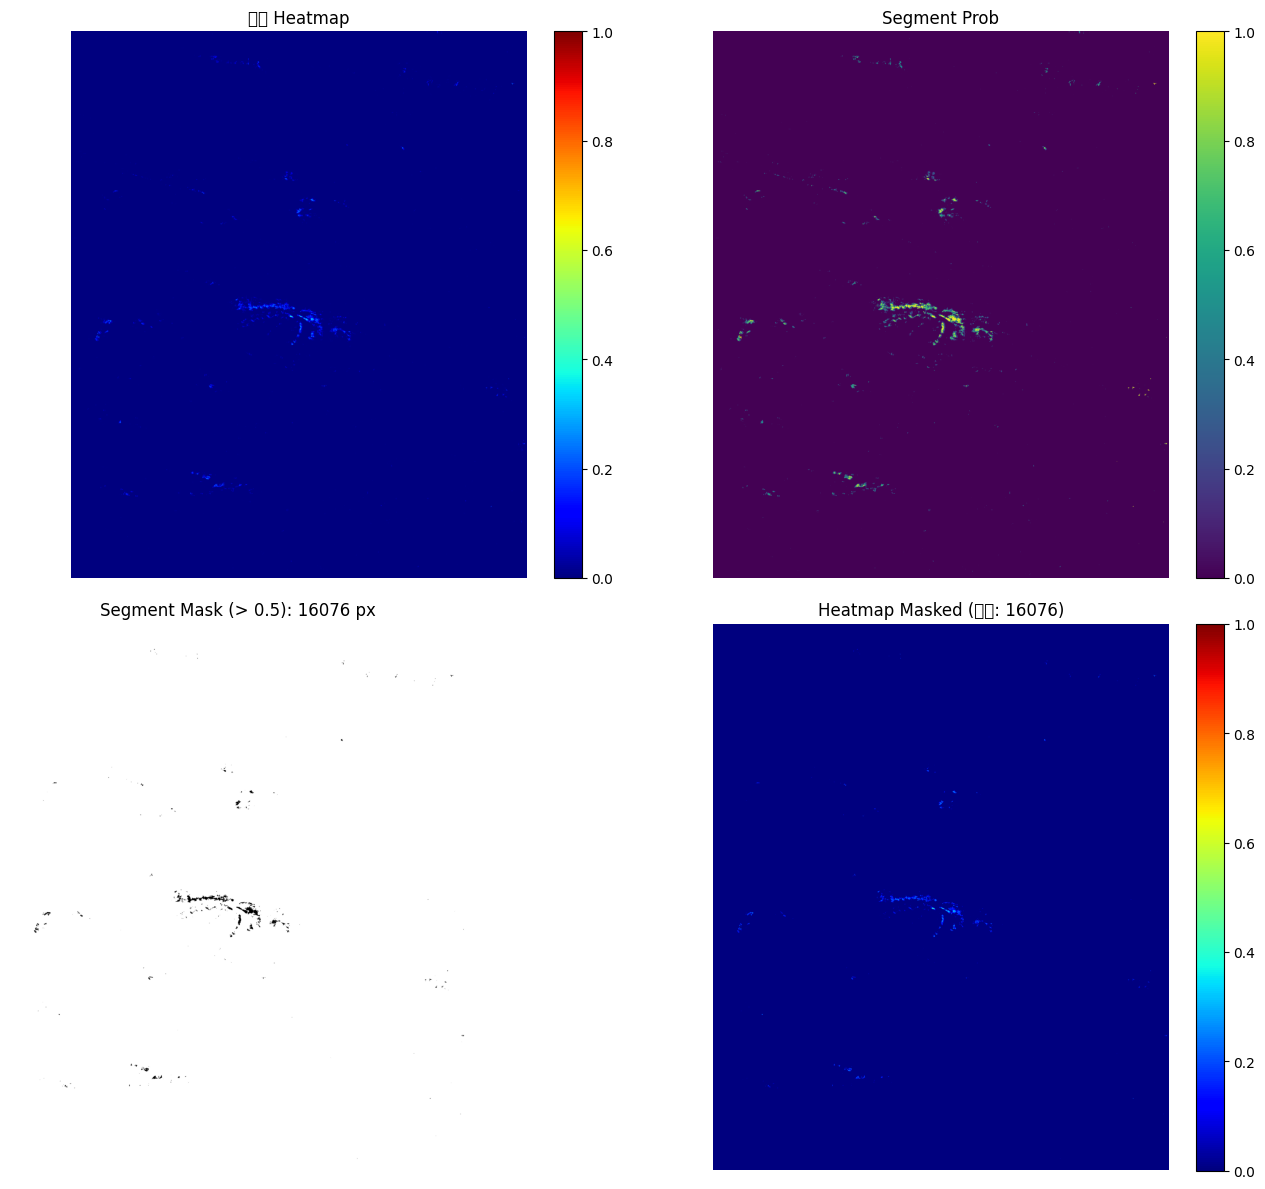

✅ 掩膜后结果已导出: /DATA/DATA1/ww/pr_mask_rts_aea_dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s/pr_mask_20170731_segmasked_0.5_unetpp_rgb_nir_dem_moco_blh_hxm.tif


In [18]:
# 用 segment > 0.5 作为掩膜筛选 heatmap 并导出

from pathlib import Path
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 读取原始预测结果
predict_path = Path(export_dir) / f"pr_mask_{test_year_t}0731_mean_unetpp_rgb_nir_dem_moco_blh_hxm.tif"

with rasterio.open(predict_path) as src:
    pr_heatmap = src.read(1)
    pr_segment = src.read(2)
    pr_count = src.read(3)
    image_count = src.read(4)
    profile = src.profile
    transform = src.transform
    crs = src.crs

# ✅ 用 segment > threshold 作为掩膜筛选 heatmap
threshold = 0.5
seg_mask = pr_segment > threshold
heatmap_masked = np.where(seg_mask, pr_heatmap, 0)

# 统计信息
print(f"掩膜阈值: segment > {threshold}")
print(f"掩膜内像素数: {seg_mask.sum()}")
print(f"原始 heatmap 非零像素: {(pr_heatmap > 0).sum()}")
print(f"掩膜后 heatmap 非零像素: {(heatmap_masked > 0).sum()}")
print(f"掩膜后 heatmap 范围: [{heatmap_masked.min():.4f}, {heatmap_masked.max():.4f}]")

# 可视化对比
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

im = axes[0, 0].imshow(pr_heatmap, cmap="jet", vmin=0, vmax=1)
axes[0, 0].set_title(f"原始 Heatmap")
axes[0, 0].axis("off")
fig.colorbar(im, ax=axes[0, 0], fraction=0.046, pad=0.04)

im = axes[0, 1].imshow(pr_segment, cmap="viridis", vmin=0, vmax=1)
axes[0, 1].set_title(f"Segment Prob")
axes[0, 1].axis("off")
fig.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)

axes[1, 0].imshow(seg_mask, cmap="Greys")
axes[1, 0].set_title(f"Segment Mask (> {threshold}): {seg_mask.sum()} px")
axes[1, 0].axis("off")

im = axes[1, 1].imshow(heatmap_masked, cmap="jet", vmin=0, vmax=1)
axes[1, 1].set_title(f"Heatmap Masked (非零: {(heatmap_masked > 0).sum()})")
axes[1, 1].axis("off")
fig.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# ✅ 导出掩膜后的结果
masked_path = Path(export_dir) / f"pr_mask_{test_year_t}0731_segmasked_{threshold}_unetpp_rgb_nir_dem_moco_blh_hxm.tif"

profile.update(count=4, dtype='float32')

with rasterio.open(masked_path, 'w', **profile) as dst:
    dst.write(heatmap_masked.astype(np.float32), 1)
    dst.write(seg_mask.astype(np.float32), 2)
    dst.write(pr_count.astype(np.float32), 3)
    dst.write(image_count.astype(np.float32), 4)
    
    dst.set_band_description(1, "heatmap_masked")
    dst.set_band_description(2, "segment_mask")
    dst.set_band_description(3, "pr_count")
    dst.set_band_description(4, "image_count")

print(f"✅ 掩膜后结果已导出: {masked_path}")

DEBUG

GT CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",90],PARAMETER["standard_parallel_1",27.5],PARAMETER["standard_parallel_2",37.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
GT bounds: [-1202148.43724525  3172399.38847666  1009448.01075267  4254618.93916753]
TIFF CRS: EPSG:32646
TIFF shape: (3096, 2577)
TIFF transform: | 29.99, 0.00, 437815.99|
| 0.00,-30.00, 3929936.56|
| 0.00, 0.00, 1.00|
TIFF bounds: (437815.9904658653, 3837062.6820999067, 515098.9866292246, 3929936.5625385013)


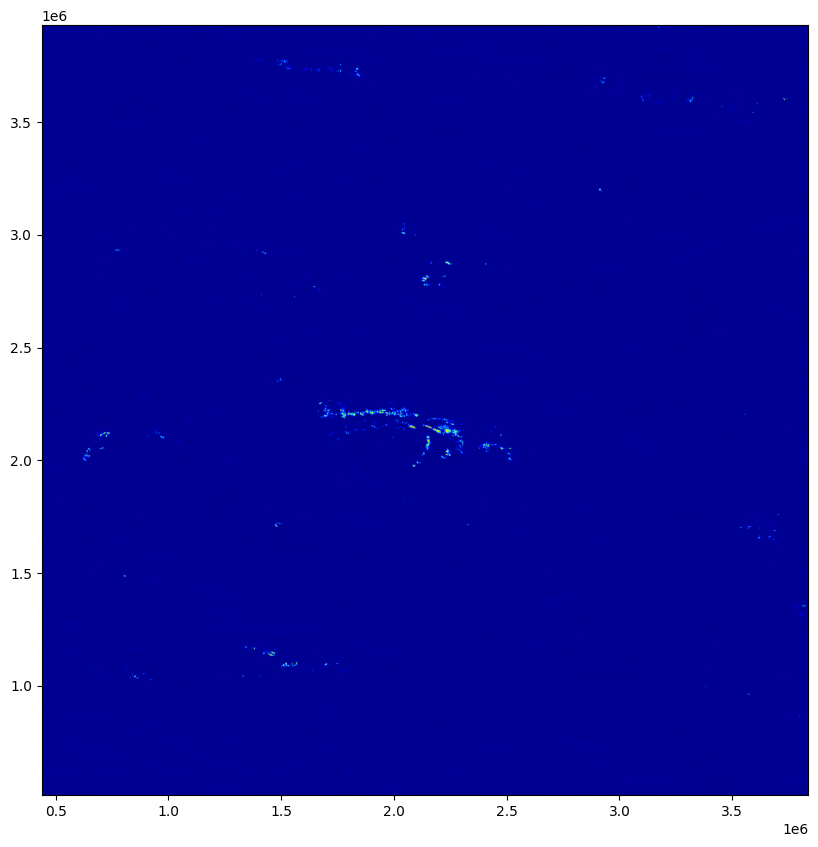

In [18]:
import geopandas as gpd

gt_path = "/home/ww/DATA1/rts-torchgeo/2017/QTP_RTS_2017.shp"
gt_gdf = gpd.read_file(gt_path)
print("GT CRS:", gt_gdf.crs)
print("GT bounds:", gt_gdf.total_bounds)

import rasterio

tif_path = "/DATA/DATA1/ww/pr_mask_rts_aea_dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s/pr_mask_20170731_median_unetpp_rgb_nir_dem_moco_blh_hxm.tif"
with rasterio.open(tif_path) as src:
    print("TIFF CRS:", src.crs)
    print("TIFF shape:", src.shape)
    print("TIFF transform:", src.transform)
    bounds = rasterio.transform.array_bounds(src.height, src.width, src.transform)
    print("TIFF bounds:", bounds)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(tif_path) as src:
    img = src.read(1)
    ax.imshow(img, extent=bounds, origin='upper', cmap='jet')
# gt_gdf.boundary.plot(ax=ax, color='red')
plt.show()